# Convert Ensemble to Function Automatically.

## Preliminaries

### Imports

In [1]:
import os
import pandas as pd
import sys
import networkx as nx

from os.path import dirname
from networkx.drawing.nx_pydot import to_pydot

note_dir = os.getcwd()

root_dir = dirname(note_dir)
src_dir = os.path.join(root_dir, "src")

sys.path.append(src_dir)

import morpheus
from morpheus.core import compose
from morpheus.tests import default_chain, default_ensemble, default_dataset
from morpheus.graph import (model_to_graph,
                            model_graph_traces,
                            model_graph_layout, 
                            convert_positions_to_dot_format,
                           add_merge_nodes)

In [2]:
from functools import partial

In [3]:
# In Greek to avoid nameclashes
ω = compose.o
χ = compose.x

### Functions

In [4]:
def fix_layout(G):
    
    for n in G.nodes():
        node = G.nodes(data=True)[n]
        if node['bipartite'] == 'func':
            node['shape'] = "\"square\""
            node['width'] = "2"
        elif node['bipartite'] == 'data':
            node['shape'] = "\"circle\""
        else:
            pass
    
    return G

### Ensemble

In [5]:
data, _ = default_dataset(random_state=16)
e = default_ensemble(random_state=16)


        Learning model with desc ids:    [0, 1, 2]
                            targ ids:    [5]
        

        Learning model with desc ids:    [0, 1, 3]
                            targ ids:    [4, 5]
        


In [6]:
data.values.shape

(800, 8)

In [7]:
data[0]

0      2.475924
1     -0.793827
2     -1.091144
3      0.044506
4      2.749476
5      2.312770
6      0.636430
7      1.607742
8     -0.253403
9     -0.174090
10    -0.047448
11     1.624632
12     1.654174
13    -0.410486
14     2.180963
15     2.116698
16    -0.040387
17     0.941200
18    -6.676288
19    -1.858783
20     0.340550
21     2.935955
22    -2.531517
23     2.152855
24    -0.377200
25     0.244075
26    -1.533570
27     1.132412
28     0.595852
29     1.019695
         ...   
770   -1.602480
771    1.477451
772   -0.862601
773    0.058659
774   -2.430258
775    1.953523
776   -0.817908
777    1.016242
778    0.195944
779   -1.949121
780    1.807277
781    1.788280
782    0.733655
783   -1.406616
784   -0.466286
785    1.565827
786    0.105812
787   -1.585288
788   -1.389415
789    3.653604
790    0.471930
791   -1.983946
792    1.061126
793    3.563686
794    1.120036
795   -1.271852
796   -3.097711
797   -0.487064
798   -1.751788
799   -3.007207
Name: 0, Length: 800, dt

In [8]:
e.pretty_print()


        # Main
        Descriptive attributes:     [0. 1. 2. 3.]
        Target attributes:          [4. 5.]

        ## On types (mostly nominals)
        Target attribute types:                     ['numeric', 'numeric']
        N_classes of nominal target attributes:     []
        Classes of nominal target attributes:       []

        ## Weights
        Total weights of target attributes:         [1. 2.]

         
        ## Estimators
        Estimators used:        ['RandomForestRegressor', 'RandomForestRegressor']
        N_estimators:           2
        


## Conversion

In [9]:
model_one = e.estimators_[0]
model_two = e.estimators_[1]

In [10]:
G_one = model_to_graph(model_one, idx=1)
G_two = model_to_graph(model_two, idx=2)

In [11]:
G = nx.compose(G_one, G_two)

In [12]:
G = fix_layout(G)

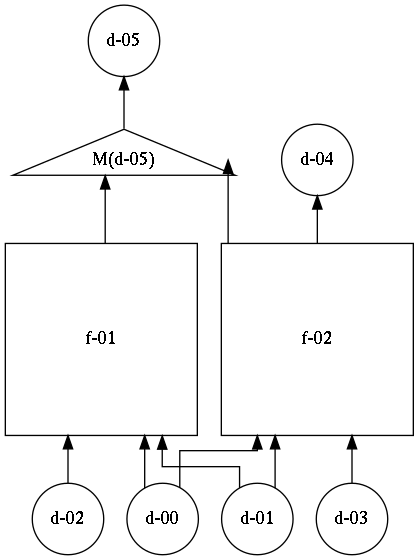

In [24]:
X = to_pydot(G)
X.set('rankdir', 'BT')
X.set('splines', 'ortho')

with open("tmp/test.dot", "w") as text_file:
    print(X.to_string(), file=text_file)
    
!dot -T png tmp/test.dot > tmp/test.png  # Bash command

from IPython.display import Image, display
from IPython.core.display import HTML 

display(Image('tmp/test.png', unconfined=True))

In [14]:
add_merge_nodes(G)

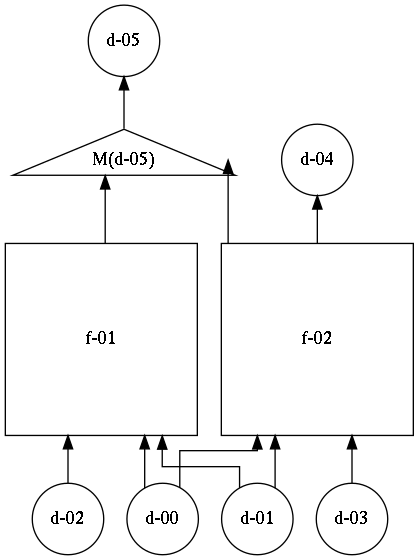

In [15]:
X = to_pydot(G)
X.set('rankdir', 'BT')
X.set('splines', 'ortho')

with open("tmp/test.dot", "w") as text_file:
    print(X.to_string(), file=text_file)
    
!dot -T png tmp/test.dot > tmp/test.png  # Bash command

from IPython.display import Image, display
from IPython.core.display import HTML 

display(Image('tmp/test.png', unconfined=True))

In [16]:
import numpy as np

def select(idx):
    
    def select(X):
        if len(X.shape) > 1:
            return X[:, idx]
        elif len(X.shape) == 1:
            assert idx == 0
            return X
    return select

In [17]:
# Convert the graph to its functions
sorted_list = list(nx.topological_sort(G))
print(sorted_list)
functions = {}
for node_name in sorted_list:
    node = G.nodes(data=True)[node_name]
    #print(node)
    if node.get('kind', None) == 'data': 
        if len(nx.ancestors(G, node_name)) == 0:
            functions[node_name] = select(node['idx'])
        elif len(nx.descendants(G, node_name)) == 0:
            functions[node_name] = 'end'
            
    elif node.get('kind', None) == 'model':
        
        previous_nodes = [t[0] for t in G.in_edges(node_name)]
        
        inputs = [functions[n] for n in previous_nodes]
        inputs = ω(np.transpose, χ(*inputs, return_type=np.array))
        f = node['function']
        functions[node_name] = ω(f, inputs)
    
    elif node.get('kind', None) == 'merge':
        merge_idx = node['idx']
        previous_nodes = [t[0] for t in G.in_edges(node_name)]
        previous_t_idx = [G.nodes()[n]['tgt'] for n in previous_nodes]
        print(previous_t_idx)
        inputs = [(functions[n],t) for n, t in zip(previous_nodes, previous_t_idx)]
        
        inputs = [ω(select(t_idx.index(merge_idx)), f) for f, t_idx in inputs]
        inputs = ω(np.transpose, χ(*inputs, return_type=np.array))
        
        f = partial(np.mean, axis=1)
        functions[node_name] = ω(f, inputs)

['d-03', 'd-02', 'd-01', 'd-00', 'f-02', 'd-04', 'f-01', 'M(d-05)', 'd-05']
[[5], [4, 5]]


In [18]:
functions

{'d-03': <function __main__.select.<locals>.select(X)>,
 'd-02': <function __main__.select.<locals>.select(X)>,
 'd-01': <function __main__.select.<locals>.select(X)>,
 'd-00': <function __main__.select.<locals>.select(X)>,
 'f-02': <function morpheus.core.compose.o.<locals>.sequential_composition(*function_arguments)>,
 'd-04': 'end',
 'f-01': <function morpheus.core.compose.o.<locals>.sequential_composition(*function_arguments)>,
 'M(d-05)': <function morpheus.core.compose.o.<locals>.sequential_composition(*function_arguments)>,
 'd-05': 'end'}

In [19]:
res = functions['M(d-05)'](data.values)


In [20]:
res.shape

(800,)

In [21]:
res

array([-4.02821104e-01,  3.23837733e-01,  4.44646642e-01, -6.79776361e-01,
       -8.95377786e-01, -7.43039178e-01,  5.79752553e-01, -5.53458944e-02,
       -1.20558075e+00,  1.95975597e-02, -3.28635546e-01, -5.73270167e-01,
        5.77118595e-01,  1.33489436e-01, -3.79469361e-01,  7.17368924e-01,
       -1.04492477e+00,  1.22496106e-01,  3.47654208e+00,  1.65382984e-01,
       -1.44754755e-01,  9.13880780e-02,  1.80527143e+00, -2.48553701e-01,
        7.64589756e-02, -3.91597567e-01,  3.67448327e-01, -5.30449192e-01,
       -2.52597685e-01, -1.43642841e-01,  2.66877405e-01,  1.11951728e+00,
       -3.91597567e-01,  9.26167059e-01,  1.94938931e-01, -1.44514108e-01,
        1.58947936e+00,  1.55840112e+00, -2.32912322e-01, -2.48818181e-01,
       -9.89525176e-01,  5.79312416e-01,  1.46298449e+00,  3.18954110e-01,
        4.46795511e-01,  1.38381151e+00, -1.14074064e+00,  8.70852681e-02,
       -1.40492826e-01,  7.42552431e-01, -3.24386186e-01, -2.56817182e-03,
       -2.79149864e-01, -

In [22]:
functions['f-01'](data.values)

array([-8.29261737e-01,  1.45784653e-01,  3.21386018e-01, -3.60061840e-02,
       -1.14993968e+00, -8.04560732e-01, -4.90974611e-01, -1.60681288e-02,
       -1.54579915e+00, -7.42192497e-02, -7.93102809e-01, -6.77081779e-01,
        3.52843834e-01,  4.33921070e-01, -6.05349322e-01, -1.63485137e-01,
       -1.02767601e-01,  1.31577842e-01,  5.47560073e+00,  5.76231796e-02,
       -7.93102809e-01,  2.77399816e-01,  1.28095235e+00, -1.63485137e-01,
       -2.55675043e-01, -1.77797244e-01,  4.77671295e-01, -3.60061840e-02,
       -7.93102809e-01, -6.77081779e-01, -1.08015803e-01,  8.61062610e-01,
       -1.77797244e-01,  3.59599084e-01,  7.23500128e-01, -1.94404555e-01,
        3.59599084e-01,  7.87211745e-01, -1.94330809e+00, -6.77081779e-01,
        2.55134352e-01, -4.22350362e-01,  4.14676136e-01, -1.63485137e-01,
       -1.65374855e-01,  1.92273152e+00, -1.79034811e+00, -9.89722526e-02,
       -7.07866701e-01, -1.65374855e-01, -5.21759533e-01,  1.01975586e+00,
       -6.77081779e-01,  

In [23]:
functions['f-02'](data.values)

array([[2.04486341, 0.02361953],
       [0.7479414 , 0.50189081],
       [0.19160987, 0.56790727],
       ...,
       [1.17966412, 0.49742349],
       [0.35587888, 0.84489149],
       [0.09189773, 0.27314279]])